# 1、import data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('feature/features_1m.csv')
labels = pd.read_csv('feature/labels_1m.csv', header=None)[1]

features_test = pd.read_csv('feature/features_test_1m.csv')

D:\Anaconda\envs\py3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2、handle data

In [2]:
features = features.drop(['shop_id'], axis=1)

features_test = features_test.drop(['shop_id'], axis=1)

In [3]:
features = features.apply(lambda x: np.log(x+1))
columns = features.columns
from sklearn.preprocessing import MinMaxScaler
features[columns] = MinMaxScaler().fit_transform(features[columns])

features_test = features_test.apply(lambda x: np.log(x+1))
features_test[columns] = MinMaxScaler().fit_transform(features_test[columns])

In [4]:
features['shop_id'] = list(range(1,3001))*6

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# 3、train & predict

In [6]:
def wmae(ground_truth, predictions):
    return abs(predictions-ground_truth).sum()/ground_truth.sum()

from sklearn.metrics import make_scorer
loss  = make_scorer(wmae, greater_is_better=False)

## 3.1 last month for reference

In [7]:
data_sales_sum = pd.read_csv('t_sales_sum.csv')
last_sales_sum = data_sales_sum[data_sales_sum['dt']=='2017-01-31']
last_sales = last_sales_sum.groupby(['shop_id'])[['sale_amt_3m']].mean().reset_index(drop=True)['sale_amt_3m']

In [8]:
last_y_train = []
for i in X_train['shop_id']:
    last_y_train.append(last_sales[i-1])
last_y_test = []
for i in X_test['shop_id']:
    last_y_test.append(last_sales[i-1])

wmae_train_last = wmae(y_train[:1000], last_y_train[:1000])
wmae_test_last = wmae(y_test, last_y_test)
print('predict train data with last sales_amt:{:.4f}'.format(wmae_train_last))
print('predict test data with last sales_amt:{:.4f}'.format(wmae_test_last))

predict train data with last sales_amt:0.3751
predict test data with last sales_amt:0.3716


## 3.2 train & predict

In [9]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, switch=1):
    if switch:
        print("{} trained on {} samples...".format(learner.__class__.__name__, sample_size))
    results = {}
    
    start = time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train time'] = end - start
    
    start = time()
    predictions_train = learner.predict(X_train[:1000])
    predictions_test = learner.predict(X_test)
    end = time()
    results['prediction time'] = end - start

    results['train_wmae'] = wmae(y_train[:1000], predictions_train)
    results['test_wmae'] = wmae(y_test, predictions_test)
    
    print(results)
    print('\n')
    return results

In [10]:
def plot_result(results, mean_wmae_train_1, mean_wmae_val):
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(2, 2, figsize = (9,7))

    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train time', 'train_wmae', 'prediction time', 'test_wmae']):
            for i in np.arange(3):

                ax[int(j/2), j%2].bar(i+k*bar_width+0.15, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[int(j/2), j%2].set_xticks([0.45, 1.45, 2.45])
                ax[int(j/2), j%2].set_xticklabels(["1%", "10%", "100%"])
                ax[int(j/2), j%2].set_xlabel("Training Set Size")
                ax[int(j/2), j%2].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("wmae Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("wmae Score")
    
    ax[0, 0].set_title("Time on Training Subset")
    ax[0, 1].set_title("wmae on Training Subset")
    ax[1, 0].set_title("Time on Predicting subset")
    ax[1, 1].set_title("wmae Score on Validation Set")
    
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    
    ax[0, 1].axhline(y = mean_wmae_train_1, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = mean_wmae_val, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-0.15, 2.6), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 14)
    
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [14]:
del X_train['shop_id']
del X_test['shop_id']
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
2465,0.740875,0.774124,0.741776,0.690107,0.323826,0.483819,0.740754,0.000000,0.575610,0.533541,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
8461,0.637024,0.767920,0.230621,0.442901,0.463746,0.694148,0.636681,0.586706,0.860798,0.470540,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
13734,0.732357,0.781753,0.000000,0.000000,0.640784,0.732592,0.731961,0.000000,0.000000,0.539824,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
965,0.518627,0.601197,0.000000,0.000000,0.000000,0.000000,0.518627,0.000000,0.000000,0.254124,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4615,0.529718,0.668798,0.000000,0.000000,0.241970,0.493736,0.529718,0.000000,0.000000,0.338508,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12167,0.810657,0.803112,0.660342,0.550894,0.411150,0.530312,0.810235,0.493215,0.749582,0.593870,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15053,0.561192,0.707200,0.557328,0.546970,0.296726,0.542025,0.561192,0.000000,0.000000,0.451544,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
17576,0.516367,0.719493,0.000000,0.000000,0.356394,0.644195,0.515794,0.516575,0.784915,0.350715,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15280,0.665143,0.714668,0.000000,0.000000,0.323826,0.485444,0.664885,0.000000,0.000000,0.478882,...,0.0,0.0,0.0,0.0,0.54588,0.0,0.0,0.0,0.0,0.0
1082,0.412624,0.609177,0.374355,0.280306,0.000000,0.000000,0.412624,0.000000,0.458393,0.267677,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


### 6.2.1 RandomForestRegressor、GradientBoostingRegressor、AdaBoostRegressor

#### 6.2.1.1 建模预测

RandomForestRegressor trained on 144 samples...
{'train time': 0.06900382041931152, 'prediction time': 0.040000200271606445, 'train_wmae': 0.4335606331283951, 'test_wmae': 0.4899233439436695}


RandomForestRegressor trained on 1440 samples...
{'train time': 0.8890044689178467, 'prediction time': 0.05000019073486328, 'train_wmae': 0.19086668920458857, 'test_wmae': 0.4890469064566391}


RandomForestRegressor trained on 14400 samples...
{'train time': 43.38646912574768, 'prediction time': 0.08300185203552246, 'train_wmae': 0.17296102140493713, 'test_wmae': 0.4535895494191021}


GradientBoostingRegressor trained on 144 samples...
{'train time': 0.22100234031677246, 'prediction time': 0.20200228691101074, 'train_wmae': 0.4354508679069255, 'test_wmae': 0.49861244415247524}


GradientBoostingRegressor trained on 1440 samples...
{'train time': 2.9770617485046387, 'prediction time': 0.21000051498413086, 'train_wmae': 0.39368971387302276, 'test_wmae': 0.48871558218703043}


GradientBoostingRegre

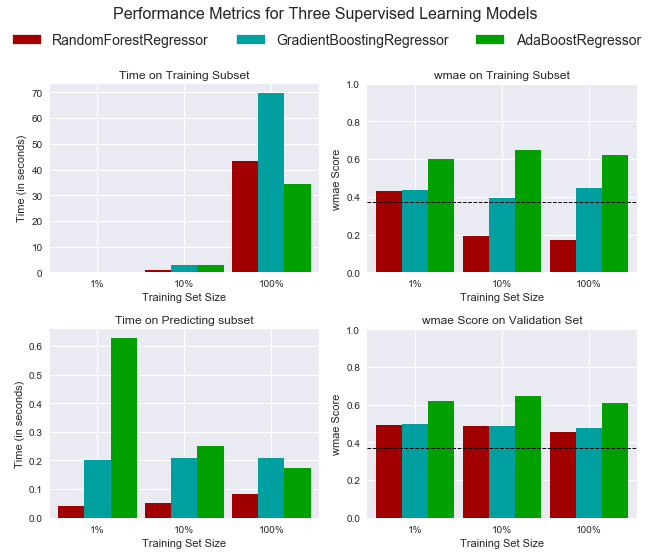

In [15]:
from time import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

reg_A = RandomForestRegressor(random_state=0)
reg_B = GradientBoostingRegressor(random_state=0)
reg_C = AdaBoostRegressor(random_state=0)

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_1 = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results_1[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_1[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
end = time()
print('3 models train & pred time:{:.4f}s'.format(end-start))
        
plot_result(results_1, wmae_train_last, wmae_test_last)

#### 6.2.1.2 调参

In [18]:
print(results_1['RandomForestRegressor'][2]['test_wmae'])
print(results_1['GradientBoostingRegressor'][2]['test_wmae'])

0.442927418296848
0.476879461223337


In [585]:
from sklearn.model_selection import GridSearchCV

reg = GradientBoostingRegressor(random_state=0)

params = {'learning_rate':[0.1, 0.2, 0.3], 'n_estimators':[90, 100, 110, 120]}

gd_search = GridSearchCV(reg, params, scoring=loss, n_jobs=-1)

gd_search.fit(features_train, labels_train)

best_reg = gd_search.best_estimator_

print(gd_search.best_params_)

{'learning_rate': 0.3, 'n_estimators': 120}


In [201]:
from sklearn.ensemble import GradientBoostingRegressor

reg_GBRs = []
for learning_rate in [0.3, 0.35, 0.4]:
    for n_estimators in [100, 120, 140]:
        reg_GBRs.append(GradientBoostingRegressor(random_state=0, learning_rate=learning_rate, n_estimators=n_estimators))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_GBRs = {}
n = 1
for reg in reg_GBRs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_GBRs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

print(results_GBRs)

GradientBoostingRegressor 1 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 2 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 3 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 4 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 5 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 6 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 7 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 8 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
GradientBoostingRegressor 9 trained on 12000 samples...
GradientBoostingRegressor trained on 12000 samples...
KNN hand_s

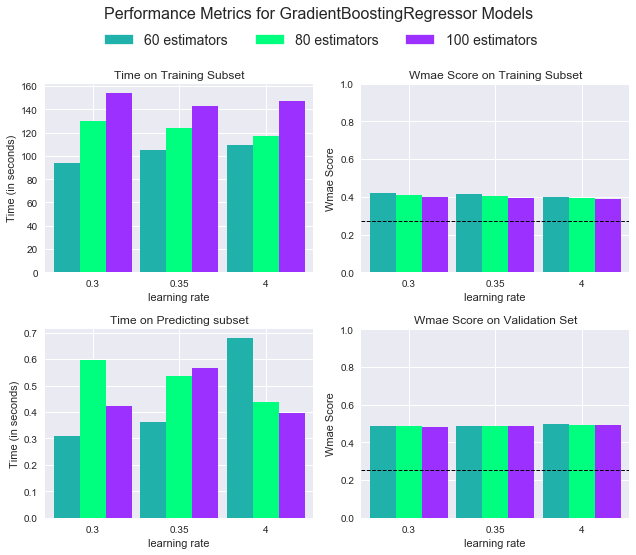

In [203]:
plot_result_GBRs(results_GBRs,mean_wmae_train, wmae_last_month)

In [202]:
def plot_result_GBRs(results, mean_wmae_train, wmae_last_month):
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(2, 2, figsize = (9,7))

    bar_width = 0.3
    colors = [ '#20B2AA', '#00FF7F', '#9B30FF']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train time', 'train_wmae', 'prediction time', 'val_wmae']):

            ax[int(j/2), j%2].bar(k*bar_width+0.15+(k//3)/10, results[learner][metric], width = bar_width, color = colors[k%3])
            ax[int(j/2), j%2].set_xticks([0.45, 1.45, 2.45])
            ax[int(j/2), j%2].set_xticklabels(["0.3", "0.35", "4"])
            ax[int(j/2), j%2].set_xlabel("learning rate")
            ax[int(j/2), j%2].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Wmae Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Wmae Score")
    
    ax[0, 0].set_title("Time on Training Subset")
    ax[0, 1].set_title("Wmae Score on Training Subset")
    ax[1, 0].set_title("Time on Predicting subset")
    ax[1, 1].set_title("Wmae Score on Validation Set")
    
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    
    ax[0, 1].axhline(y = mean_wmae_train, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = wmae_last_month, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    patches = []
    n_estimators = [60, 80, 100]
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i%3], label = '{} estimators'.format(n_estimators[i%3])))
    plt.legend(handles = patches[:3], bbox_to_anchor = (-0.15, 2.6), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 14)
    
    plt.suptitle("Performance Metrics for GradientBoostingRegressor Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [586]:
best_predictions = best_reg.predict(features_val)
best_wmae = wmae(labels_val, best_predictions)
print(best_wmae)

0.51543770711121


In [657]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

strat = time()
reg = GradientBoostingRegressor(random_state=0)

params_rm = {'learning_rate':[0.01,0.1,0.3,0.5], 'n_estimators':sp_randint(90,130)}

rm_search = RandomizedSearchCV(reg, param_distributions=params_rm, scoring=loss, n_iter=20, n_jobs=-1)

rm_search.fit(features_train, labels_train)

best_reg_rm = rm_search.best_estimator_
end = time()
print('random search time:{:.4f}s'.format(end-start))
print(rm_search.best_params_)

best_predictions = best_reg.predict(features_val)
best_wmae = wmae(labels_val, best_predictions)
print(best_wmae)

random search time:46450.7871s
{'learning_rate': 0.5, 'n_estimators': 128}
0.51543770711121


**GradientBoostingRegressor 在val上为0.51543770711121**

In [ ]:
reg_KNNs = []
for neighbors in [3, 4, 5]:
    for p in [1, 2, 3]:
        for algo in ['ball_tree','kd_tree','brute']:
            reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p, algorithm=algo))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, features_train, labels_train, features_val, labels_val)
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, sample_100))
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))
        

#### 6.2.1.3生成最终结果

In [686]:
submission_rm_gbr = pd.DataFrame()
submission_rm_gbr['shop_id'] = shops['shop_id']
submission_rm_gbr['pred_amt'] = best_predictions
submission_rm_gbr = submission_rm_gbr.groupby('shop_id')[['pred_amt']].mean()
submission_rm_gbr.to_csv('submission_rm_gbr.csv', header=False)
submission_rm_gbr

      shop_id       pred_amt
0           1  170312.078142
1           2   49249.323500
2           3  163876.157307
3           4   85151.760002
4           5   61404.215936
5           6  114690.333135
6           7   78626.273434
7           8  142780.393861
8           9  238775.702435
9          10   61404.215936
10         11  159550.498188
11         12   84563.684268
12         13   53600.226268
13         14   45877.512300
14         15   92655.417929
15         16   96684.153847
16         17  106447.667504
17         18   61404.215936
18         19   53464.804583
19         20   91070.873590
20         21   61404.215936
21         22  108349.612822
22         23   79866.985329
23         24  111167.147785
24         25  118322.067727
25         26  123278.218948
26         27   89271.608301
27         28  159840.388074
28         29  116835.040352
29         30   84361.091615
...       ...            ...
2970     2971  325359.974888
2971     2972  157124.645954
2972     2973 

,pred_amt
shop_id,
1,170312.078142
2,49249.323500
3,163876.157307
4,85151.760002
5,61404.215936
6,114690.333135
7,78626.273434
8,142780.393861
9,238775.702435


### 6.2.2 KNeighborsRegressor、DecisionTreeRegression、SVR

#### 6.2.2.1 建模预测

In [21]:
from time import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

reg_D = KNeighborsRegressor(n_jobs=-1)
reg_E = DecisionTreeRegressor()
reg_F = SVR(kernel='linear')

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_2 = {}
for reg in [reg_D, reg_E, reg_F]:
    reg_name = reg.__class__.__name__
    results_2[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_2[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
end = time()
print('3 model train & pred time:{:.4f}s'.format(end-start))
        
plot_result(results_2, wmae_train_last, wmae_test_last)

KNeighborsRegressor trained on 144 samples...
{'train time': 0.29300808906555176, 'prediction time': 1.1808562278747559, 'train_wmae': 0.5713485169305677, 'test_wmae': 0.6171990361783313}


KNeighborsRegressor trained on 1440 samples...
{'train time': 0.23620343208312988, 'prediction time': 7.940043210983276, 'train_wmae': 0.4549931082701016, 'test_wmae': 0.5792887294122228}


KNeighborsRegressor trained on 14400 samples...
{'train time': 4.89461088180542, 'prediction time': 46.04168128967285, 'train_wmae': 0.273864206492469, 'test_wmae': 0.38718290239558517}


DecisionTreeRegressor trained on 144 samples...
{'train time': 0.15600013732910156, 'prediction time': 0.09400129318237305, 'train_wmae': 0.48214649977985913, 'test_wmae': 0.568540788283056}


DecisionTreeRegressor trained on 1440 samples...
{'train time': 0.14420223236083984, 'prediction time': 0.031199932098388672, 'train_wmae': 0.0, 'test_wmae': 0.6145964390723808}


DecisionTreeRegressor trained on 14400 samples...
{'train t

NameError: name 'mean_wmae_train' is not defined

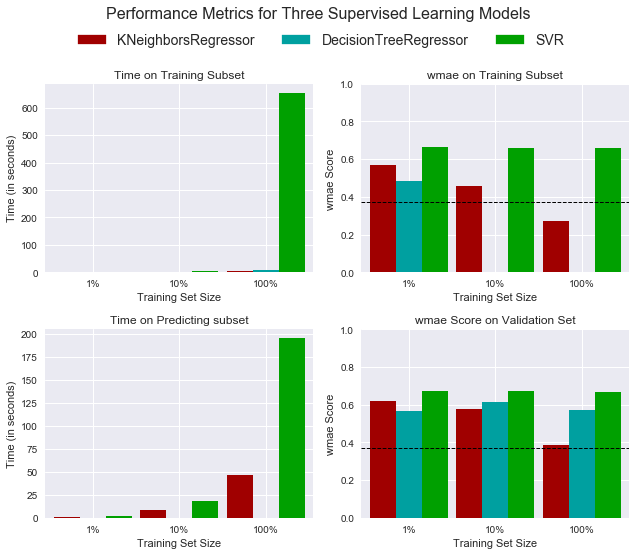

In [22]:
plot_result(results_2, wmae_train_last, wmae_test_last)

#### 6.2.2.2 调参

In [20]:
results_2['KNeighborsRegressor'][2]['test_wmae']

0.40510694593007174

In [ ]:
from sklearn.model_selection import GridSearchCV

start = time()
reg_2 = KNeighborsRegressor(n_jobs=-1)

params = {'n_neighbors':[2,3,4], 'p':[1,2,3]}

gd_search_KNN = GridSearchCV(reg_2, params, scoring=loss, n_jobs=-1)

gd_search_KNN.fit(features_train, labels_train)

best_reg_KNN = gd_search_KNN.best_estimator_

print(gd_search_KNN.best_params_)


best_predictions_KNN = best_reg_KNN.predict(features_val)
best_wmae__KNN = wmae(labels_val, best_predictions_KNN)
print(best_wmae_KNN)
end = time()
print('gs time:{:.4f}'.format(end-start))

with shop_id feature

In [158]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [3,4,5]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

KNeighborsRegressor 1 trained on 12000 samples...
{'train time': 4.011444330215454, 'prediction time': 37.92919087409973, 'train_wmae': 0.21537091813268378, 'test_wmae': 0.3486958420752345}


KNeighborsRegressor 2 trained on 12000 samples...
{'train time': 4.752809762954712, 'prediction time': 31.62235951423645, 'train_wmae': 0.21858779874401082, 'test_wmae': 0.3447368938929253}


KNeighborsRegressor 3 trained on 12000 samples...
{'train time': 4.964610576629639, 'prediction time': 166.02284598350525, 'train_wmae': 0.2197768515092907, 'test_wmae': 0.3485031697108714}


KNeighborsRegressor 4 trained on 12000 samples...
{'train time': 4.9998109340667725, 'prediction time': 80.37812662124634, 'train_wmae': 0.2700372502326354, 'test_wmae': 0.3749333573869658}


KNeighborsRegressor 5 trained on 12000 samples...
{'train time': 6.4702136516571045, 'prediction time': 60.34471654891968, 'train_wmae': 0.27091195711037697, 'test_wmae': 0.38051255991139715}


KNeighborsRegressor 6 trained on 12000

NameError: name 'plot_result_KNNs' is not defined

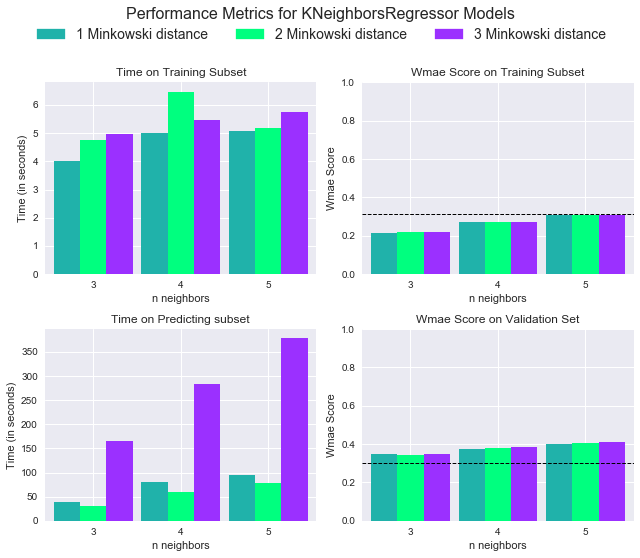

In [160]:
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

KNeighborsRegressor 1 trained on 12000 samples...
{'train time': 4.290245294570923, 'prediction time': 9.73155665397644, 'train_wmae': 0.0, 'test_wmae': 0.30800817663201807}


KNeighborsRegressor 2 trained on 12000 samples...
{'train time': 4.737270832061768, 'prediction time': 5.793331623077393, 'train_wmae': 0.0, 'test_wmae': 0.3019223037500578}


KNeighborsRegressor 3 trained on 12000 samples...
{'train time': 4.985285043716431, 'prediction time': 24.634408950805664, 'train_wmae': 0.0, 'test_wmae': 0.30058163997452775}


KNeighborsRegressor 4 trained on 12000 samples...
{'train time': 5.05328893661499, 'prediction time': 33.31690573692322, 'train_wmae': 0.17288763315841874, 'test_wmae': 0.32230003782136907}


KNeighborsRegressor 5 trained on 12000 samples...
{'train time': 5.3313047885894775, 'prediction time': 20.762187719345093, 'train_wmae': 0.16755882331398717, 'test_wmae': 0.3061241406239861}


KNeighborsRegressor 6 trained on 12000 samples...
{'train time': 7.390422821044922, 

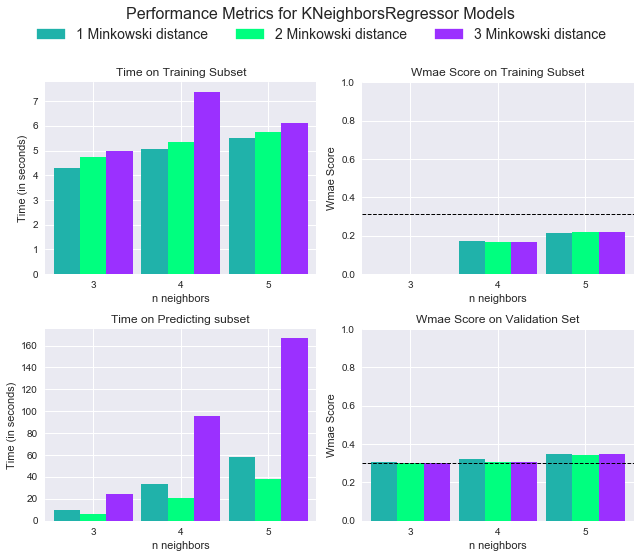

In [99]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [1,2,3]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

In [159]:
# results_KNNs_aft = {}
# for i in range(len(results_KNNs)):
#     if (i+3)%3 == 0:
#         results_KNNs_aft[int((i+3)/3)] = results_KNNs['{}'.format(i+1)]
# print(results_KNNs_aft)

# plot_result_KNNs(results_KNNs_aft, mean_wmae_train, wmae_last_month)
plot_result_KNNs(results_KNNs, mean_wmae_train, wmae_last_month)

NameError: name 'results_KNNs' is not defined

In [159]:
def plot_result_KNNs(results, mean_wmae_train, wmae_last_month):
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(2, 2, figsize = (9,7))

    bar_width = 0.3
    colors = [ '#20B2AA', '#00FF7F', '#9B30FF']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train time', 'train_wmae', 'prediction time', 'test_wmae']):

            ax[int(j/2), j%2].bar(k*bar_width+0.15+(k//3)/10, results[learner][metric], width = bar_width, color = colors[k%3])
            ax[int(j/2), j%2].set_xticks([0.45, 1.45, 2.45])
            ax[int(j/2), j%2].set_xticklabels(["3", "4", "5"])
            ax[int(j/2), j%2].set_xlabel("n neighbors")
            ax[int(j/2), j%2].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Wmae Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Wmae Score")
    
    ax[0, 0].set_title("Time on Training Subset")
    ax[0, 1].set_title("Wmae Score on Training Subset")
    ax[1, 0].set_title("Time on Predicting subset")
    ax[1, 1].set_title("Wmae Score on Validation Set")
    
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    
    ax[0, 1].axhline(y = mean_wmae_train, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = wmae_last_month, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i%3], label = '{} Minkowski distance'.format(learner)))
    plt.legend(handles = patches[:3], bbox_to_anchor = (-0.15, 2.6), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 14)
    
    plt.suptitle("Performance Metrics for KNeighborsRegressor Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

#### 6.2.2.3 预测并生成最终结果

In [161]:
reg_KNN_best = KNeighborsRegressor(n_jobs=-1, n_neighbors=3, p=2)
reg_KNN_best.fit(features.drop('shop_id', axis=1), labels)
predictions_KNN_best = reg_KNN_best.predict(features_test)

In [162]:
submission_rm_knn = pd.DataFrame()
submission_rm_knn['shop_id'] = range(1, 3001)
submission_rm_knn['pred_amt'] = predictions_KNN_best
submission_rm_knn = submission_rm_knn.groupby('shop_id')[['pred_amt']].mean()
submission_rm_knn.to_csv('submission_knn_3_full.csv', header=False)

**提交一** 6181111为**0.786665。**     

 **提交二：**KNN 为**0.582138**（val上为0.3965415249333668）（submission_rm_knn.csv）

**提交三**：KNN为**0.645001**（val上为0.30058163997452775）（submission_sklearn_1.csv）

### 6.2.3 LinearRegression、Ridge、SGDRegressor

#### 6.2.4.1 建模

LinearRegression trained on 144 samples...
{'train time': 0.07200407981872559, 'prediction time': 0.16400575637817383, 'train_wmae': 1.1375283014991604, 'test_wmae': 1.2744927098621304}


LinearRegression trained on 1440 samples...
{'train time': 1.6040318012237549, 'prediction time': 0.15500402450561523, 'train_wmae': 0.2146838551123161, 'test_wmae': 2274170815837.6353}


LinearRegression trained on 14400 samples...
{'train time': 28.96200704574585, 'prediction time': 0.14400339126586914, 'train_wmae': 0.3064247120526338, 'test_wmae': 0.3697418663082975}


Ridge trained on 144 samples...
{'train time': 0.028001070022583008, 'prediction time': 0.11400127410888672, 'train_wmae': 0.5382188123354272, 'test_wmae': 0.5932010295681192}


Ridge trained on 1440 samples...
{'train time': 0.6520302295684814, 'prediction time': 0.13600587844848633, 'train_wmae': 0.31208548971403444, 'test_wmae': 0.5601873136675644}


Ridge trained on 14400 samples...
{'train time': 4.873236656188965, 'prediction 

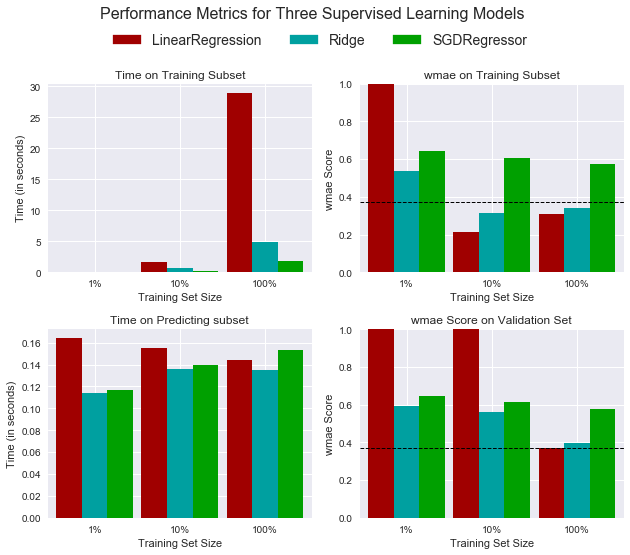

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

reg_G = LinearRegression()
reg_H = Ridge(random_state=0)
reg_I = SGDRegressor(random_state=0)

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_3 = {}
for reg in [reg_G, reg_H, reg_I]:
    reg_name = reg.__class__.__name__
    results_3[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_3[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
end = time()
print('3 model train & pred time:{:.4f}s'.format(end-start))
        
plot_result(results_3, wmae_train_last, wmae_test_last)

#### 6.2.4.2调参

In [15]:
print(results_3['LinearRegression'][2]['test_wmae'])
print(results_3['Ridge'][2]['test_wmae'])

0.3704742617590044
0.40630651817009167


[LinearRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)可调参数有限 

In [ ]:
from sklearn.linear_model import LinearRegression

reg_LineReg = []
for neighbors in [3, 4, 5]:
    for p in [2, 3, 4]:
        reg_LineReg.append(LinearRegression(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, features_train, labels_train, features_val, labels_val)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

print(results_KNNs)
# plot_result(results_2, mean_wmae_train, mean_wmae_val)

### 6.2.4 ElasticNet、Lasso、BayesianRidge

#### 6.2.4.1 建模

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge

reg_G = ElasticNet(random_state=0)
reg_H = Lasso(random_state=0)
reg_I = BayesianRidge()

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_4 = {}
for reg in [reg_G, reg_H, reg_I]:
    reg_name = reg.__class__.__name__
    results_4[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_4[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
end = time()
print('3 model train & pred time:{:.4f}s'.format(end-start))
        
plot_result(results_4, wmae_train_last, wmae_test_last)

ElasticNet trained on 144 samples...
{'train time': 0.2140035629272461, 'prediction time': 0.09280276298522949, 'train_wmae': 0.6658201726969941, 'test_wmae': 0.6720992269549112}


ElasticNet trained on 1440 samples...
{'train time': 0.12580037117004395, 'prediction time': 0.062399864196777344, 'train_wmae': 0.6660173949949347, 'test_wmae': 0.6697624433794521}


ElasticNet trained on 14400 samples...
{'train time': 1.595836877822876, 'prediction time': 0.07800006866455078, 'train_wmae': 0.667884380769143, 'test_wmae': 0.6705848004168856}


Lasso trained on 144 samples...


D:\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'train time': 0.18720030784606934, 'prediction time': 0.10280323028564453, 'train_wmae': 0.5045437794155163, 'test_wmae': 0.5956441535248208}


Lasso trained on 1440 samples...
{'train time': 1.852829933166504, 'prediction time': 0.06220197677612305, 'train_wmae': 0.14394132493088788, 'test_wmae': 0.6435321645470479}


Lasso trained on 14400 samples...
{'train time': 38.31698799133301, 'prediction time': 0.08140110969543457, 'train_wmae': 0.3084211441569422, 'test_wmae': 0.3717326122483764}


BayesianRidge trained on 144 samples...
{'train time': 1.1314094066619873, 'prediction time': 0.08540129661560059, 'train_wmae': 0.7195177305905375, 'test_wmae': 0.7174870754123436}


BayesianRidge trained on 1440 samples...
{'train time': 22.027748346328735, 'prediction time': 0.062399864196777344, 'train_wmae': 0.42404753674702533, 'test_wmae': 0.5645659119574887}


BayesianRidge trained on 14400 samples...


LinAlgError: SVD did not converge

#### 6.2.4.2调参

In [17]:
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
13136,0.525938,0.434594,0.535288,0.386164,0.292543,0.473223,0.526451,0.417936,0.000000,0.463188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3536,0.673916,0.552176,0.735637,0.677998,0.325876,0.456494,0.674755,0.561756,0.811361,0.557004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,0.700546,0.760895,0.753636,0.764285,0.695784,0.852296,0.701285,0.585267,0.862821,0.557435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,0.545042,0.476824,0.516359,0.392145,0.408958,0.571535,0.545834,0.000000,0.000000,0.430397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14775,0.542250,0.649126,0.610506,0.492984,0.335292,0.804995,0.543038,0.471806,0.702526,0.465150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10575,0.362985,0.326103,0.000000,0.000000,0.227643,0.454863,0.363512,0.000000,0.000000,0.308788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11938,0.679979,0.627217,0.741666,0.688818,0.513669,0.644625,0.680901,0.362821,0.304196,0.589713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11006,0.744841,0.685561,0.794296,0.736665,0.545102,0.664123,0.745504,0.000000,0.660302,0.663790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7937,0.753400,0.685339,0.109124,0.241694,0.524352,0.675973,0.754212,0.000000,0.000000,0.598897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13178,0.409374,0.339510,0.137699,0.191224,0.279157,0.488719,0.409969,0.000000,0.000000,0.366810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print(results_4['Lasso'][2]['test_wmae'])

0.3709972589233897


In [18]:
from sklearn.linear_model import Lasso

reg_Lassoes = []
for alpha in [0.2, 0.3, 0.4]:
    reg_Lassoes.append(Lasso(random_state=0, alpha=alpha))

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_Lassoes = {}
n = 1
for reg in reg_Lassoes:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_Lassoes['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('Lasso hand_search time:{:.4f}s'.format(end-start))

print(results_Lassoes)
# plot_result(results_2, mean_wmae_train, mean_wmae_val)

Lasso 1 trained on 12000 samples...


D:\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'train time': 221.25665521621704, 'prediction time': 0.3560202121734619, 'train_wmae': 0.2982140364819531, 'test_wmae': 0.36966746267947953}


Lasso 2 trained on 12000 samples...
{'train time': 202.021555185318, 'prediction time': 0.3210182189941406, 'train_wmae': 0.29846505703322035, 'test_wmae': 0.36959401731068275}


Lasso 3 trained on 12000 samples...
{'train time': 185.946635723114, 'prediction time': 0.2760157585144043, 'train_wmae': 0.2988027952224839, 'test_wmae': 0.3695818149547699}


Lasso hand_search time:610.1849s
{'1': {'train time': 221.25665521621704, 'prediction time': 0.3560202121734619, 'train_wmae': 0.2982140364819531, 'test_wmae': 0.36966746267947953}, '2': {'train time': 202.021555185318, 'prediction time': 0.3210182189941406, 'train_wmae': 0.29846505703322035, 'test_wmae': 0.36959401731068275}, '3': {'train time': 185.946635723114, 'prediction time': 0.2760157585144043, 'train_wmae': 0.2988027952224839, 'test_wmae': 0.3695818149547699}}


In [20]:
features_test

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
0,0.619744,0.747410,0.558906,0.547771,0.624067,0.713227,0.619670,0.665626,0.617772,0.508525,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,0.595253,0.619525,0.522908,0.463385,0.509721,0.618102,0.594868,0.000000,0.000000,0.472737,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,0.556513,0.692637,0.531714,0.513732,0.635247,0.728054,0.556639,0.867813,0.806323,0.403262,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.470860,0.517596,0.337292,0.412970,0.216882,0.359715,0.470614,0.798311,0.801496,0.383845,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,0.611613,0.777641,0.579657,0.569595,0.532109,0.681871,0.611751,0.610831,0.570324,0.703797,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
5,0.670122,0.643548,0.676823,0.755272,0.171875,0.310180,0.670273,0.000000,0.603569,0.777408,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
6,0.733522,0.760908,0.796450,0.762589,0.468675,0.559738,0.733474,0.000000,0.000000,0.624547,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
7,0.633427,0.751860,0.703103,0.752112,0.452192,0.600238,0.633570,0.827931,0.844085,0.483018,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
8,0.778790,0.895799,0.833289,0.707047,0.637921,0.690925,0.778936,0.000000,0.000000,0.723263,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
9,0.384325,0.459510,0.474411,0.424540,0.304433,0.548412,0.384412,0.000000,0.000000,0.252671,...,0.0,1.0,0.0,0.0,0.75523,0.000000,0.0,0.0,0.0,0.0


In [21]:
reg_Lasso_best = Lasso(random_state=0, alpha=0.4)
reg_Lasso_best.fit(features.drop('shop_id', axis=1), labels)
predictions_Lasso_best = reg_Lasso_best.predict(features_test)

D:\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [32]:
baseline = pd.read_csv('other/submission_baseline.csv', header=None)[1].tolist()
predictions_Lasso_best_rec = predictions_Lasso_best.tolist()
n = 0
for i in range(len(predictions_Lasso_best_rec)):
    if predictions_Lasso_best_rec[i] < 0:
        predictions_Lasso_best_rec[i] = baseline[i]
        n += 1
print(n)

90


In [39]:
submission_lasso = pd.DataFrame()
submission_lasso['shop_id'] = range(1, 3001)
submission_lasso['pred_amt'] = predictions_Lasso_best_rec
submission_lasso = submission_lasso.groupby('shop_id')[['pred_amt']].mean()
submission_lasso.to_csv('submission_lasso_04_full_rec.csv', header=False)

### 6.2.5 KernelRidge、GaussianProcessRegressor、HuberRegressor

#### 6.2.5.1 建模

KernelRidge trained on 144 samples...
{'train time': 0.10500597953796387, 'prediction time': 0.45902347564697266, 'train_wmae': 0.5676069483600706, 'test_wmae': 0.62287911813176}


KernelRidge trained on 1440 samples...
{'train time': 0.49201536178588867, 'prediction time': 0.8680429458618164, 'train_wmae': 0.32138799830802595, 'test_wmae': 0.5813664852631565}


KernelRidge trained on 14400 samples...
{'train time': 56.99671006202698, 'prediction time': 5.264288663864136, 'train_wmae': 0.3383941165989089, 'test_wmae': 0.3971695962163985}


GaussianProcessRegressor trained on 144 samples...
{'train time': 0.11900711059570312, 'prediction time': 3.3281593322753906, 'train_wmae': 0.5198088334679973, 'test_wmae': 0.6318293384643932}


GaussianProcessRegressor trained on 1440 samples...
{'train time': 10.316450119018555, 'prediction time': 30.420280933380127, 'train_wmae': 1.9410814145642837e-09, 'test_wmae': 0.715578115806612}


GaussianProcessRegressor trained on 14400 samples...
{'train 

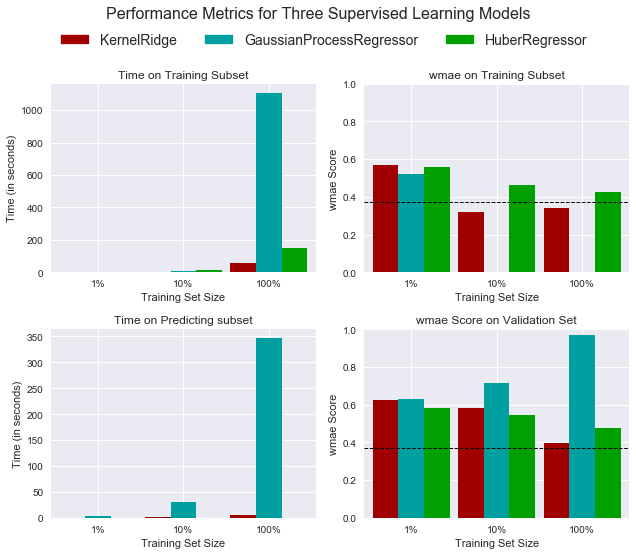

In [18]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import HuberRegressor

reg_J = KernelRidge()
reg_K = GaussianProcessRegressor(random_state=0)
reg_L = HuberRegressor()

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_5 = {}
for reg in [reg_J, reg_K, reg_L]:
    reg_name = reg.__class__.__name__
    results_5[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_5[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
end = time()
print('3 model train & pred time:{:.4f}s'.format(end-start))
        
plot_result(results_5, wmae_train_last, wmae_test_last)

In [37]:
results_2

{'DecisionTreeRegressor': {0: {'prediction time': 0.1360034942626953,
   'test_wmae': 0.6590020844885726,
   'train time': 0.15900039672851562,
   'train_wmae': 0.6215932372193577},
  1: {'prediction time': 0.07800030708312988,
   'test_wmae': 0.6012885211071679,
   'train time': 0.516007661819458,
   'train_wmae': 0.0},
  2: {'prediction time': 0.09360027313232422,
   'test_wmae': 0.5695373846178188,
   'train time': 18.270054578781128,
   'train_wmae': 0.0}},
 'KNeighborsRegressor': {0: {'prediction time': 1.8402431011199951,
   'test_wmae': 0.5929078395762657,
   'train time': 0.041002511978149414,
   'train_wmae': 0.5834837536100694},
  1: {'prediction time': 16.281630992889404,
   'test_wmae': 0.5790593338794665,
   'train time': 0.9286088943481445,
   'train_wmae': 0.47440672891370317},
  2: {'prediction time': 87.23915648460388,
   'test_wmae': 0.40510694593007174,
   'train time': 16.009037971496582,
   'train_wmae': 0.309535271657765}},
 'SVR': {0: {'prediction time': 5.341218

In [60]:
len(results_all)

15

#### 6.2.5.2 调参

GPR is really great, nearly unbelievable. Actually, **fake**

with shop_id features

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from time import time

reg_K = GaussianProcessRegressor(random_state=0)

start = time()
reg_K.fit(X_train, y_train)
end = time()
print('GaussianProcessRegression train time;{:.4f}s'.format(end-start))

start = time()
pred_gpr = reg_K.predict(X_test)
end = time()
print('GaussianProcessRegression predict time:{:.4f}s'.format(end-start))
print('wmae of gpr:{:.4f}s'.format(wmae(y_test, pred_gpr)))

GaussianProcessRegression train time;655.7898s
GaussianProcessRegression predict time:150.6867s
wmae of gpr:0.3521s


In [ ]:
a = pd.DataFrame()
a['real'] = y_test
a['gpr'] = pred_gpr
print(a[a['gpr']<0].shape)
a

In [ ]:
result_gpr = reg_K.predict(features_test)
result_gpr

In [22]:
a = pd.DataFrame(result_gpr)
a[a[0]<0]

NameError: name 'result_gpr' is not defined

In [17]:
features_test['shop_id'] = range(1,3001)

In [18]:
reg_K = GaussianProcessRegressor(random_state=0)
reg_K.fit(features, labels)

prediction_gpr = reg_K.predict(features_test)

In [19]:
data_sales_sum = pd.read_csv('t_sales_sum.csv')
data_sales_sum_last = data_sales_sum[data_sales_sum['dt']=='2017-01-31'].groupby('shop_id')[['sale_amt_3m']].mean()['sale_amt_3m']
data_sales_sum_last

shop_id
1       219097.84
2        79214.06
3       134667.29
4        47633.91
5       233025.51
6       105927.87
7       189101.04
8       207094.16
9       447212.23
10       33373.05
11      227926.47
12      146061.99
13       42115.62
14      122426.50
15      250954.45
16      340421.66
17      339309.01
18       42579.64
19       76240.07
20      113332.50
21       45987.53
22      161232.86
23       39113.11
24      276138.30
25       45762.08
26      243194.75
27      102129.36
28      684223.00
29      450845.01
30       86080.58
          ...    
2971    483800.50
2972    277341.70
2973    228094.41
2974    139921.63
2975    219168.56
2976    320012.22
2977     22840.14
2978    215978.12
2979     20113.66
2980     74962.54
2981      9860.75
2982    623455.35
2983    158838.89
2984     44657.50
2985     80011.97
2986     41490.21
2987     12422.37
2988     87948.54
2989    512352.91
2990    217663.32
2991     14366.67
2992    134478.36
2993     25553.73
2994     27617.71
29

In [20]:
b = pd.DataFrame()
b['gpr'] = result_gpr
b['real'] = data_sales_sum_last
b['gpr_full'] = prediction_gpr

print(b[b['gpr_full']<0].shape)
b[100:200]

NameError: name 'result_gpr' is not defined

without shop_id features

In [94]:
del X_train['shop_id']
del X_test['shop_id']
del features_test['shop_id']
features_test

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
0,0.619744,0.747410,0.558906,0.547771,0.624067,0.713227,0.619670,0.665626,0.617772,0.508525,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,0.595253,0.619525,0.522908,0.463385,0.509721,0.618102,0.594868,0.000000,0.000000,0.472737,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,0.556513,0.692637,0.531714,0.513732,0.635247,0.728054,0.556639,0.867813,0.806323,0.403262,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.470860,0.517596,0.337292,0.412970,0.216882,0.359715,0.470614,0.798311,0.801496,0.383845,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,0.611613,0.777641,0.579657,0.569595,0.532109,0.681871,0.611751,0.610831,0.570324,0.703797,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
5,0.670122,0.643548,0.676823,0.755272,0.171875,0.310180,0.670273,0.000000,0.603569,0.777408,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
6,0.733522,0.760908,0.796450,0.762589,0.468675,0.559738,0.733474,0.000000,0.000000,0.624547,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
7,0.633427,0.751860,0.703103,0.752112,0.452192,0.600238,0.633570,0.827931,0.844085,0.483018,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
8,0.778790,0.895799,0.833289,0.707047,0.637921,0.690925,0.778936,0.000000,0.000000,0.723263,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
9,0.384325,0.459510,0.474411,0.424540,0.304433,0.548412,0.384412,0.000000,0.000000,0.252671,...,0.0,1.0,0.0,0.0,0.75523,0.000000,0.0,0.0,0.0,0.0


In [95]:
from sklearn.gaussian_process import GaussianProcessRegressor

reg_K = GaussianProcessRegressor(random_state=0)

start = time()
reg_K.fit(X_train, y_train)
end = time()
print('GaussianProcessRegression train time;{:.4f}s'.format(end-start))

start = time()
pred_gpr = reg_K.predict(X_test)
end = time()
print('GaussianProcessRegression predict time:{:.4f}s'.format(end-start))
print('wmae of gpr:{:.4f}s'.format(wmae(y_test, pred_gpr)))

GaussianProcessRegression train time;660.8898s
GaussianProcessRegression predict time:162.8563s
wmae of gpr:0.6224s


### 6.2.6 Voting（KNN、Lasso、LinearRegressor）

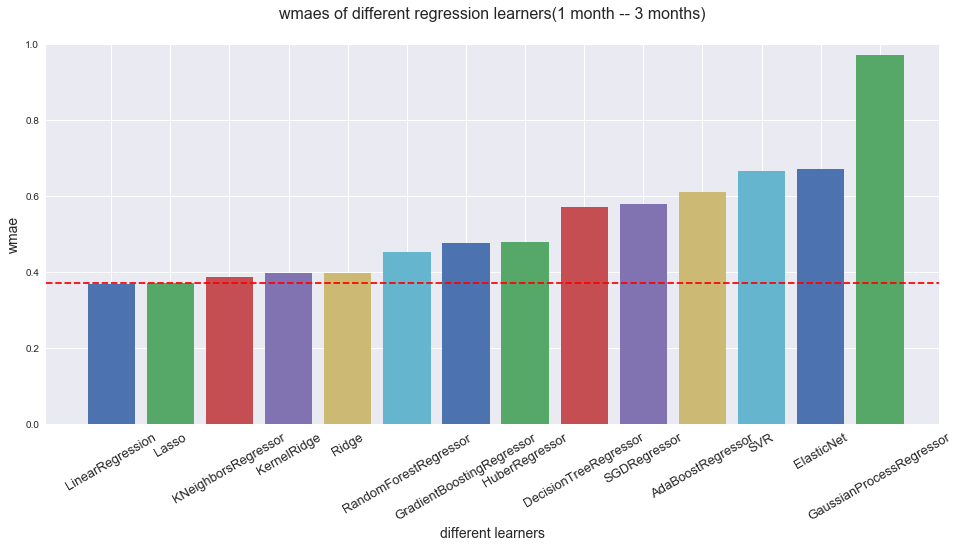

In [27]:
from collections import ChainMap
results_all = dict(ChainMap(results_1, results_2, results_3, results_4, results_5))
del results_all['BayesianRidge']

x = range(1, len(results_all)+1)
learners = list(results_all.keys())

wmaes = []
for learner in learners:
    wmaes.append(results_all[learner][2]['test_wmae'])
wmaes = np.array(wmaes)
indexes = np.argsort(wmaes)
learners_sorted = []
for index in indexes:
    learners_sorted.append(learners[index])
    
fig, ax = plt.subplots(1,1, figsize = (16,7))
i = 0
for learner in learners_sorted:
    ax.bar(i+1, results_all[learner][2]['test_wmae'], width=0.8)
    i += 1
    
plt.plot([-0.1, len(learners)+1], [wmae_test_last, wmae_test_last], 'r', linestyle='--')

ax.set_xticks(list(x))
ax.set_xticklabels(learners_sorted, rotation=30, fontsize=13)
ax.set_xlim((-0.1, len(learners)+1))
ax.set_ylim((0, 1.0))

plt.xlabel('different learners', fontsize=14)
plt.ylabel('wmae', fontsize=14)
plt.title('wmaes of different regression learners(1 month -- 3 months)', fontsize=16, y=1.05)

plt.show()

In [163]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

reg_vote1 = KNeighborsRegressor(n_jobs=-1, n_neighbors=3, p=3)
reg_vote2 = Lasso(random_state=0)
reg_vote3 = LinearRegression()

start = time()
reg_vote1.fit(features_train, labels_train)
pred_vote1 = reg_vote1.predict(features_val)
end = time()
print('reg_vote1 train and pred time: {:.4f}s'.format(end - start))

start = time()
reg_vote2.fit(features_train, labels_train)
pred_vote2 = reg_vote2.predict(features_val)
end = time()
print('reg_vote2 train and pred time: {:.4f}s'.format(end - start))

start = time()
reg_vote3.fit(features_train, labels_train)
pred_vote3 = reg_vote3.predict(features_val)
end = time()
print('reg_vote3 train and pred time: {:.4f}s'.format(end - start))

reg_vote1 train and pred time: 108.4592s


D:\Anaconda\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


reg_vote2 train and pred time: 106.7625s
reg_vote3 train and pred time: 40.4703s


In [176]:
print('wmae KNN:{:.6f}'.format(wmae(labels_val, pred_vote1)))
print('wmae Lasso:{:.6f}'.format(wmae(labels_val, pred_vote2)))
print('wmae LineRegre:{:.6f}'.format(wmae(labels_val, pred_vote3)))

wmae KNN:0.396542
wmae Lasso:0.474679
wmae LineRegre:0.471986


In [177]:
pred_vote = 0.8*pred_vote1+0.1*pred_vote2+0.1*pred_vote3
wmae(labels_val, pred_vote)

0.39969736705641973